In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
from os.path import join

from scseirx.model_uni import SEIRX_uni
from scseirx import viz

In [2]:
agent_types = {
        'unistudent':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':False,
            'vaccination_ratio': 0.0},
        'lecturer':{
            'screening_interval': None,
            'index_probability': 0,
            'mask':True,
            'vaccination_ratio': 0.0}
}

In [3]:
measures = {
    # enables testing and tracing actions (run with testing=False) to simulate
    # unhindered spread of the virus through the nursing home
    'testing':'diagnostic',
    # test technology and turnover time used for preventive screening
    'preventive_screening_test_type':'same_day_antigen',
    # test technology and turnover time used for diagnostic testing
    'diagnostic_test_type':'two_day_PCR',
    # definition of contact types that will be quarantined in case one
    # of the agents in contact had a positive test result
    'K1_contact_types':['close'],
    # duration (in days) that agents will stay quarantined
    'quarantine_duration':10,
    # interval of a potential follow-up background screen (in days)
    # after a background screen that was initiated by a positive test
    'follow_up_testing_interval':None,
    # whether or not a negative test result "frees" agents from quarantine
    'liberating_testing':False,
    # modification of the transmission risk by ventilation 
    # (1 = no modification, 0.5 = risk is reduced by 50%)
    'ventilation_modification':1,
    # modification of the transmission risk by vaccination
    # (0 = no modification, 0.95 = risk reduction of BioN-Tech/Pfizer and Moderna) 
    'vaccination_modification':{'reception':0.6, 'transmission':0.0}
}

In [4]:
model_params = {
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and becoming infectious (in days)
    'exposure_duration':[5.0, 1.9], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and showing symptoms in clinical courses
    # of the infection (in days)
    'time_until_symptoms':[6.4, 0.8], # literature values
    # mean and variance of a Weibull distribution characterizing the
    # time between transmission and ceasing to be infectious (in days)
    'infection_duration':[10.91, 3.95], # literature values
    # modification of the transmission risk in subclinical courses
    'subclinical_modifier':0.6, 
    # base transmission risk of a contact of type "close"
    'base_risk':0.5, # artificially high, so you can see stuff happening
    # efficiency of masks (surgical), reducing the transmission risk
    # (exhale) if the source wears a mask and/or the reception risk 
    # (inhale), if the target (also) wears a mask
    'mask_filter_efficiency':{'exhale':0.5, 'inhale':0.7}, # literature values
    # modifiers of the base_risk for transmissions of contact type close
    # if the contact type is "intermediate", "far" or "very var"
    'infection_risk_contact_type_weights':\
        {'very_far':0, 'far':0.3, 'intermediate':0.3,'close':1}, # calibrated
    # agent group from which the index case is drawn
    'index_case':'unistudent',
    # days of data in the contact network,
    'N_days_in_network':128,
    # verbosity level (can be 0, 1, 2) that prints increasingly detailed 
    # information about the simulation
    'verbosity':0
}

In [10]:
network_src = 'data/uni'
network_name = 'test_uni_0.25_all.bz2'
# interaction network of students, teachers and household members
G = nx.readwrite.gpickle.read_gpickle(join(network_src, network_name))
# number of steps (days) the simulation will run
N_steps = 50

# fixed seed of the simulation, using the same seed repeats the 
# same simulation if the same parameters are chosen. Setting 
# seed = None corresponds to a random initialization.
seed = 1

# initialize the model with all the relevant parameters, measures and agent
# types
model = SEIRX_uni(G, model_params['verbosity'], 
      base_transmission_risk = model_params['base_risk'], 
      testing = measures['testing'],
      exposure_duration = model_params['exposure_duration'],
      time_until_symptoms = model_params['time_until_symptoms'],
      infection_duration = model_params['infection_duration'],
      quarantine_duration = measures['quarantine_duration'],
      subclinical_modifier = model_params['subclinical_modifier'], 
      infection_risk_contact_type_weights = \
            model_params['infection_risk_contact_type_weights'], 
      K1_contact_types = measures['K1_contact_types'],
      diagnostic_test_type = measures['diagnostic_test_type'],
      preventive_screening_test_type = \
            measures['preventive_screening_test_type'],
      follow_up_testing_interval = \
            measures['follow_up_testing_interval'],
      liberating_testing = measures['liberating_testing'],
      index_case = model_params['index_case'],
      agent_types = agent_types,
      mask_filter_efficiency = model_params['mask_filter_efficiency'],
      transmission_risk_ventilation_modifier = \
            measures['ventilation_modification'],
      N_days_in_network = model_params["N_days_in_network"],
      seed=seed)

# expose the agent with the most connections on the first day to see stuff
# happening
agent_id = max(dict(model.day_connections[1].degree()).items(),
               key = lambda x : x[1])[0]
a = [a for a in model.schedule.agents if a.ID == agent_id][0]
a.exposed = True

# run the model
for i in range(N_steps):
    if model_params['verbosity'] > 0: print('*** step {} ***'.format(i+1))
    model.step()

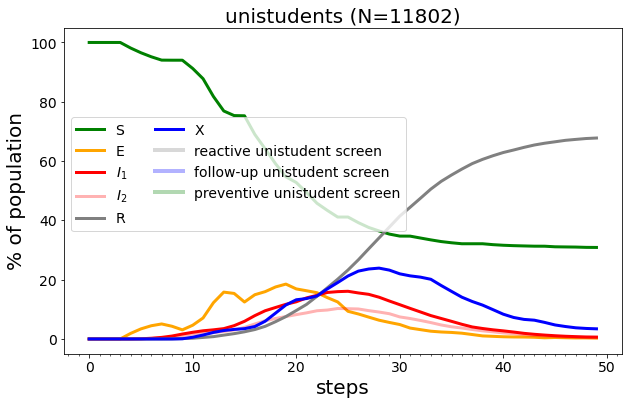

In [11]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'unistudent', ax)

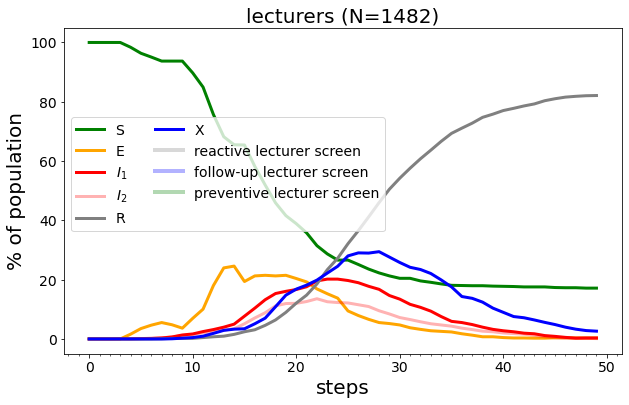

In [12]:
fig, ax = plt.subplots(figsize=(10, 6))
viz.draw_infection_timeline(model, 'lecturer', ax)

### Have a peek at the raw data

In [13]:
data = model.datacollector.get_model_vars_dataframe()
data.head(5)

,S_unistudent,E_unistudent,I_unistudent,I_asymptomatic_unistudent,I_symptomatic_unistudent,R_unistudent,X_unistudent,V_unistudent,S_lecturer,E_lecturer,...,screen_lecturers_preventive,N_diagnostic_tests,N_preventive_screening_tests,diagnostic_test_detected_infections_unistudent,diagnostic_test_detected_infections_lecturer,preventive_test_detected_infections_unistudent,preventive_test_detected_infections_lecturer,undetected_infections,predetected_infections,pending_test_infections
0,11801,1,0,0,0,0,0,0,1481,1,...,False,0,0,0,0,0,0,0,0,0
1,11801,1,0,0,0,0,0,0,1481,1,...,False,0,0,0,0,0,0,0,0,0
2,11801,1,0,0,0,0,0,0,1481,1,...,False,0,0,0,0,0,0,0,0,0
3,11801,1,0,0,0,0,0,0,1481,0,...,False,0,0,0,0,0,0,0,0,0
4,11580,221,1,1,0,0,0,0,1457,24,...,False,0,0,0,0,0,0,0,0,0
